I'm curious about the generalization of features learned by sparse autoencoders across multiple layers of a language model. Specifically, are there features that occur in the same latent space across multiple layers? To test this, I'm going to train a sparse autoencoder on a mix of activations from multiple layers, and use it to attempt to detect interpretable features. There are a few reasons why I find this interesting:
1. more generalized features
2. feature progression - the work of relating the features from different layers 
3. If it is possible to train an interpretable autoencoder on the activations of multiple layers, then could it be further trained on individual layers, and still produce an interpretable set of features? If so this could speed up training, scaling well with layer count, but also may produce features which more clearly relate between layers.

From the start I see some immediate challenges with this:
1. The norm of the residual stream grows with further layers, which may lead to later features overshadowing earlier ones. This may be addressable by renormalizing activations depending on their layer of origin, but it may be more complicated, see [here](https://www.alignmentforum.org/posts/8mizBCm3dyc432nK8/residual-stream-norms-grow-exponentially-over-the-forward#Theories_for_the_source_of_the_growth)
2. Two features from different layers may fully co-occur, but if they are in different latent spaces then they may not be learned as the same feature, or may not be learned at all. In general, I am broadly uncertain about the self-consistency of the residual stream, since there doesn't seem to be particularly strong pressure for its space to remain the same across the length of the model.

I believe that the ultimate odds of success for this are fairly low, but that it may lead to something interesting nonetheless.

Things I'd like to try:
- perhaps some subsections of the layers are more consistent, even if the whole isn't. For example, I suspect that the first and last layers may be doing something notably different, whereas the operations of the middle layers are more consistent


In [1]:
from transformer_lens import HookedTransformer
from datasets import load_dataset
import torch
import gc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
seed = 42
torch.manual_seed(seed)

In [3]:
dataset_name = "roneneldan/TinyStories"
model_name = "gpt2"

In [75]:
dataset = load_dataset(dataset_name).shuffle(seed=seed)

Repo card metadata block was not found. Setting CardData to empty.


In [76]:
model = HookedTransformer.from_pretrained(model_name, device="cuda")

Loaded pretrained model gpt2 into HookedTransformer


In [6]:
num_seqs = 1024
batch_size = 32
max_seq_length = 256
num_layers = 12

In [7]:
# Calculate the average norm of the activations of each layer, over 1024 sequences of length 256

norm_sums = torch.zeros(num_layers, device="cuda")
num_samples = 0
act_names = [f"blocks.{i}.hook_mlp_out" for i in range(num_layers)]
for i in tqdm(range(0, num_seqs, batch_size)):
    tokens = model.tokenizer(dataset["train"]["text"][i:i + batch_size], max_length=max_seq_length, truncation=True,
                             padding=True, return_tensors="pt")["input_ids"]
    output, cache = model.run_with_cache(tokens, names_filter=act_names)
    mlp_out_norm_sums = torch.stack([cache[act_name].norm(p=2, dim=-1).sum() for act_name in act_names])
    seq_length = cache[act_names[0]].shape[-2]  # should be equal to max_seq_length

    norm_sums += mlp_out_norm_sums
    num_samples += (batch_size * seq_length)

    del output, cache
    gc.collect()
    torch.cuda.empty_cache()

avg_norms = norm_sums / num_samples
avg_norms

  0%|          | 0/32 [00:00<?, ?it/s]

tensor([ 31.9579,  13.6317,  21.0553,  16.2032,  14.5199,  16.1118,  19.7167,
         27.0147,  29.6941,  42.1604,  77.3804, 113.6636], device='cuda:0')

In [8]:
avg_norms = avg_norms.cpu().tolist()

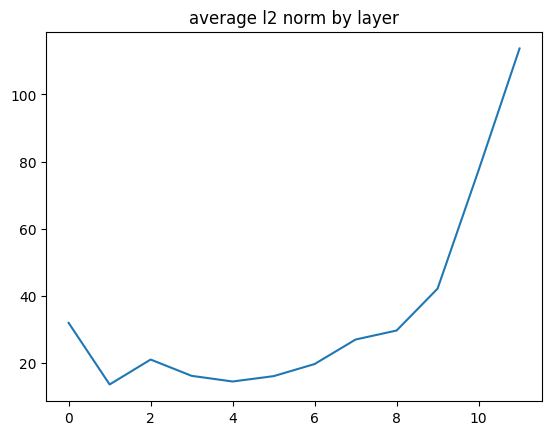

In [9]:
plt.plot(avg_norms)
plt.title("average l2 norm by layer")
plt.show()

It's unclear to me what the best way to normalize the activations going into the multi-layer autoencoder is. I think that the naive solution of scaling each layers acts by its relative norm shown above would lose something, since its unclear how much of the growing norm is an artifact that doesn't represent anything vs. more information/features actually being calculated from one layer to the next. Perhaps scaling by the sqrt or log of the relative norm would work better? This is all very speculative. I think I'll have to do a sweep of different scaling functions and constants.

In [12]:
# cleanup
del model, dataset, tokens
gc.collect()
torch.cuda.empty_cache()

In [13]:
from buffer import *
from autoencoder_sweeper import *

In [14]:
%env WANDB_SILENT=true

env: WANDB_SILENT=true


In [ ]:
layers = list(range(12))

# Buffer to easily generate/store activations from the model, automatically refills the buffer when it drops below a certain size,
# and then shuffles it to avoid activations from the same sequence being used together
buffer_cfg = ActivationsBufferConfig(
    model_name=model_name,
    layers=layers,
    dataset_name=dataset_name,
    dataset_split="train",
    act_site="hook_mlp_out",
    device="cuda",
    buffer_device="cpu",
    buffer_size=2 ** 18,
    model_batch_size=32,
    samples_per_seq=1024,
    seed=seed
)

buffer = ActivationsBuffer(buffer_cfg)

In [7]:
# Performs a simple grid sweep over the outer product of the parameters, including
# learning rate, beta1, beta2, lambda_reg, warmup_percent, and layer
# Logs to wandb
sweeper_cfg = AutoEncoderSweeperConfig(
    n_dim=768,
    m_dim=768 * 4,
    lr=[1e-3],
    beta1=[0],
    beta2=[0.99],
    lambda_reg=torch.logspace(start=-5, end=-3, steps=8).tolist(),
    warmup_percent=[0.05],
    layer=layers,
    act_norms=None,
    act_renorm_type=[],
    act_renorm_scale=[],
    parallelism=16,
    batch_size=2048,
    total_activations=int(2e8),
    wb_project="multilayer_sae",
    wb_entity="collingray",
    wb_group=f"layer_lreg_sweep",
)

sweeper = AutoEncoderSweeper(sweeper_cfg, buffer)

In [ ]:
torch.multiprocessing.set_start_method('spawn', force=True)  # needed to keep cuda happy
sweeper.run()

This sweep runs 8 different lambda regularization factors for each of the 12 layers. The full results can be seen [here](https://wandb.ai/collingray/multilayer_sae/groups/layer_lreg_sweep/workspace?nw=nwusercollingray), but the most relevant piece is shown below - the FVU vs L0, for each layer. (For the interactive version, see the link)

The pareto front between fvu and sparsity seems to follow a similar concave trend to the norm of the feature activation, with the early and final layers being shifted down/left, and the middle layers up/right. We even see the same pattern of layer #1 being a local outlier to this curve. This makes sense, if the set of activations for each layer is approximately centered, since in that case the average of the variance of each feature should be approximately equal to the average of the squared l2 norms.

I don't think that this explains the entirety of the shift however, since the average l2 norm is higher on the later layers compared to the earlier layers, but the down/left shift of the fvu-sparsity front is more even between early and later layers.

The exact implications this has for training a multi-layer autoencoder are unclear - it does push me further towards believing that there is a gradient of something like # of "true" interpretable features across layers that is not shown through the average norm per layer. The clusters here may also suggest some layers which would be good to train together, e.g. 3, 4, 5, and 6. This is all highly speculative, but worth testing.

Perhaps fvu shouldn't be used here (or should be scaled by average norm)

It also makes me curious about what the effect of weighing l0 differently depending on the layer being run. My intuitions are that this makes no sense, but I do wonder what it would look like.

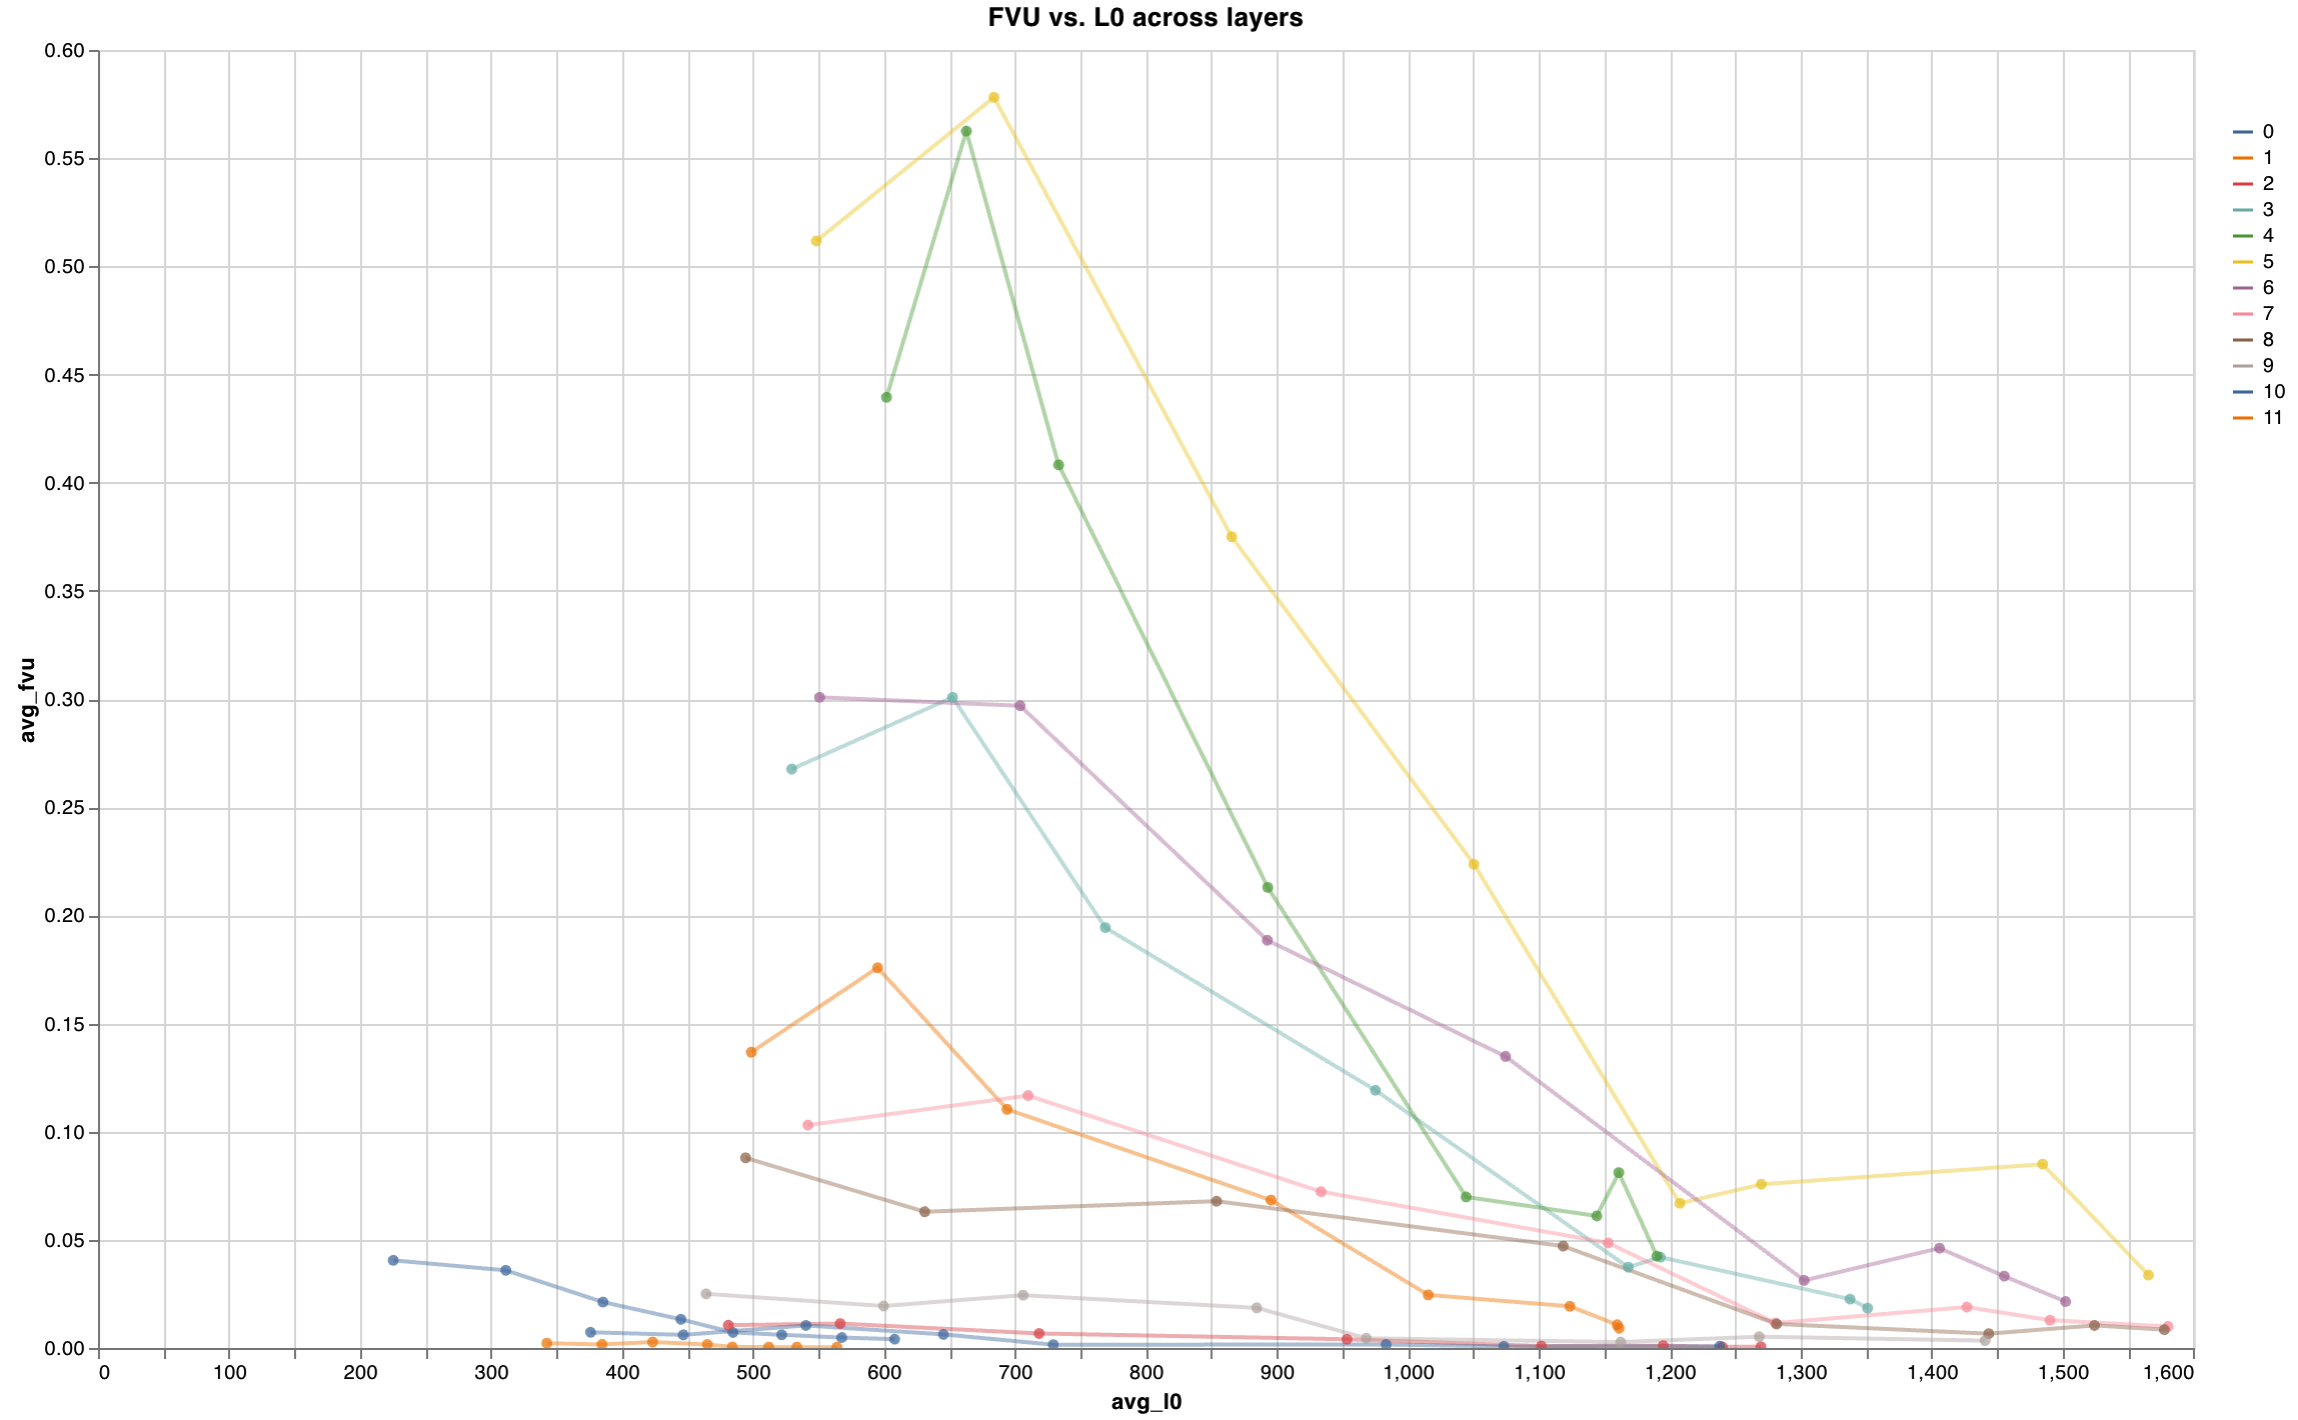

In [37]:
from IPython.display import Image

Image(filename='/home/collin/autoencoders/fvu_l0_layers.png')

In [34]:
# Grid sweep over multilayer autoencoder configurations, using the average norms calculated above, 
# a range of lambda regularization factors, and learning rates, and 4 different activation renormalization types
sweeper_cfg = AutoEncoderSweeperConfig(
    n_dim=768,
    m_dim=768 * 4,
    lr=[2e-3, 1e-3, 5e-4],
    beta1=[0],
    beta2=[0.99],
    lambda_reg=torch.logspace(start=-5, end=-3, steps=4).tolist(),
    warmup_percent=[0.05],
    layer=layers,
    act_norms=avg_norms,
    act_renorm_type=["linear", "sqrt", "log", "none"],
    act_renorm_scale=[1],
    parallelism=8,
    batch_size=1024,
    total_activations=int(5e7),
    wb_project="multilayer_sae",
    wb_entity="collingray",
    wb_group=f"renorm_lreg_sweep",
)

sweeper = AutoEncoderSweeper(sweeper_cfg, buffer)

In [35]:
torch.multiprocessing.set_start_method('spawn', force=True)
sweeper.run()

Running sweep with 48 configurations
Running configs 1 to 8 of 48


  0%|          | 0/48828 [00:00<?, ?it/s]

Running configs 9 to 16 of 48


  0%|          | 0/48828 [00:00<?, ?it/s]

Running configs 17 to 24 of 48


  0%|          | 0/48828 [00:00<?, ?it/s]

Running configs 25 to 32 of 48


  0%|          | 0/48828 [00:00<?, ?it/s]

Running configs 33 to 40 of 48


  0%|          | 0/48828 [00:00<?, ?it/s]

Running configs 41 to 48 of 48


  0%|          | 0/48828 [00:00<?, ?it/s]

This sweep tested 3 different learning rates, 4 different lambda regularization factors, and 4 different activation renormalization types. The primary results can be seen [here](https://api.wandb.ai/links/collingray/2z27z7ue), and all data collected can be seen [here](https://wandb.ai/collingray/multilayer_sae/groups/renorm_lreg_sweep/workspace?nw=8kaxrdcaemb).

The primary reason for this sweep was to see what effect rescaling the activations of each layer based on their average norm would have. The four options tested were "linear", "sqrt", "log", and "none", where "none" is no rescaling, and each other option takes the avg norm per layer (calculated above), maps it by the square root, base10 log, or nothing in the case of linear, and then rescales the incoming activations such that they match the average of these mapped values. (this is hard to follow but the technique is simple, see autoencoder_multilayer.py)

The results show that this increases both the average L1 and MSE, averaged over all layers, over the length of the run - not good.

However, broken down into average L1 and MSE by layer (shown below), we see a more interesting effect.

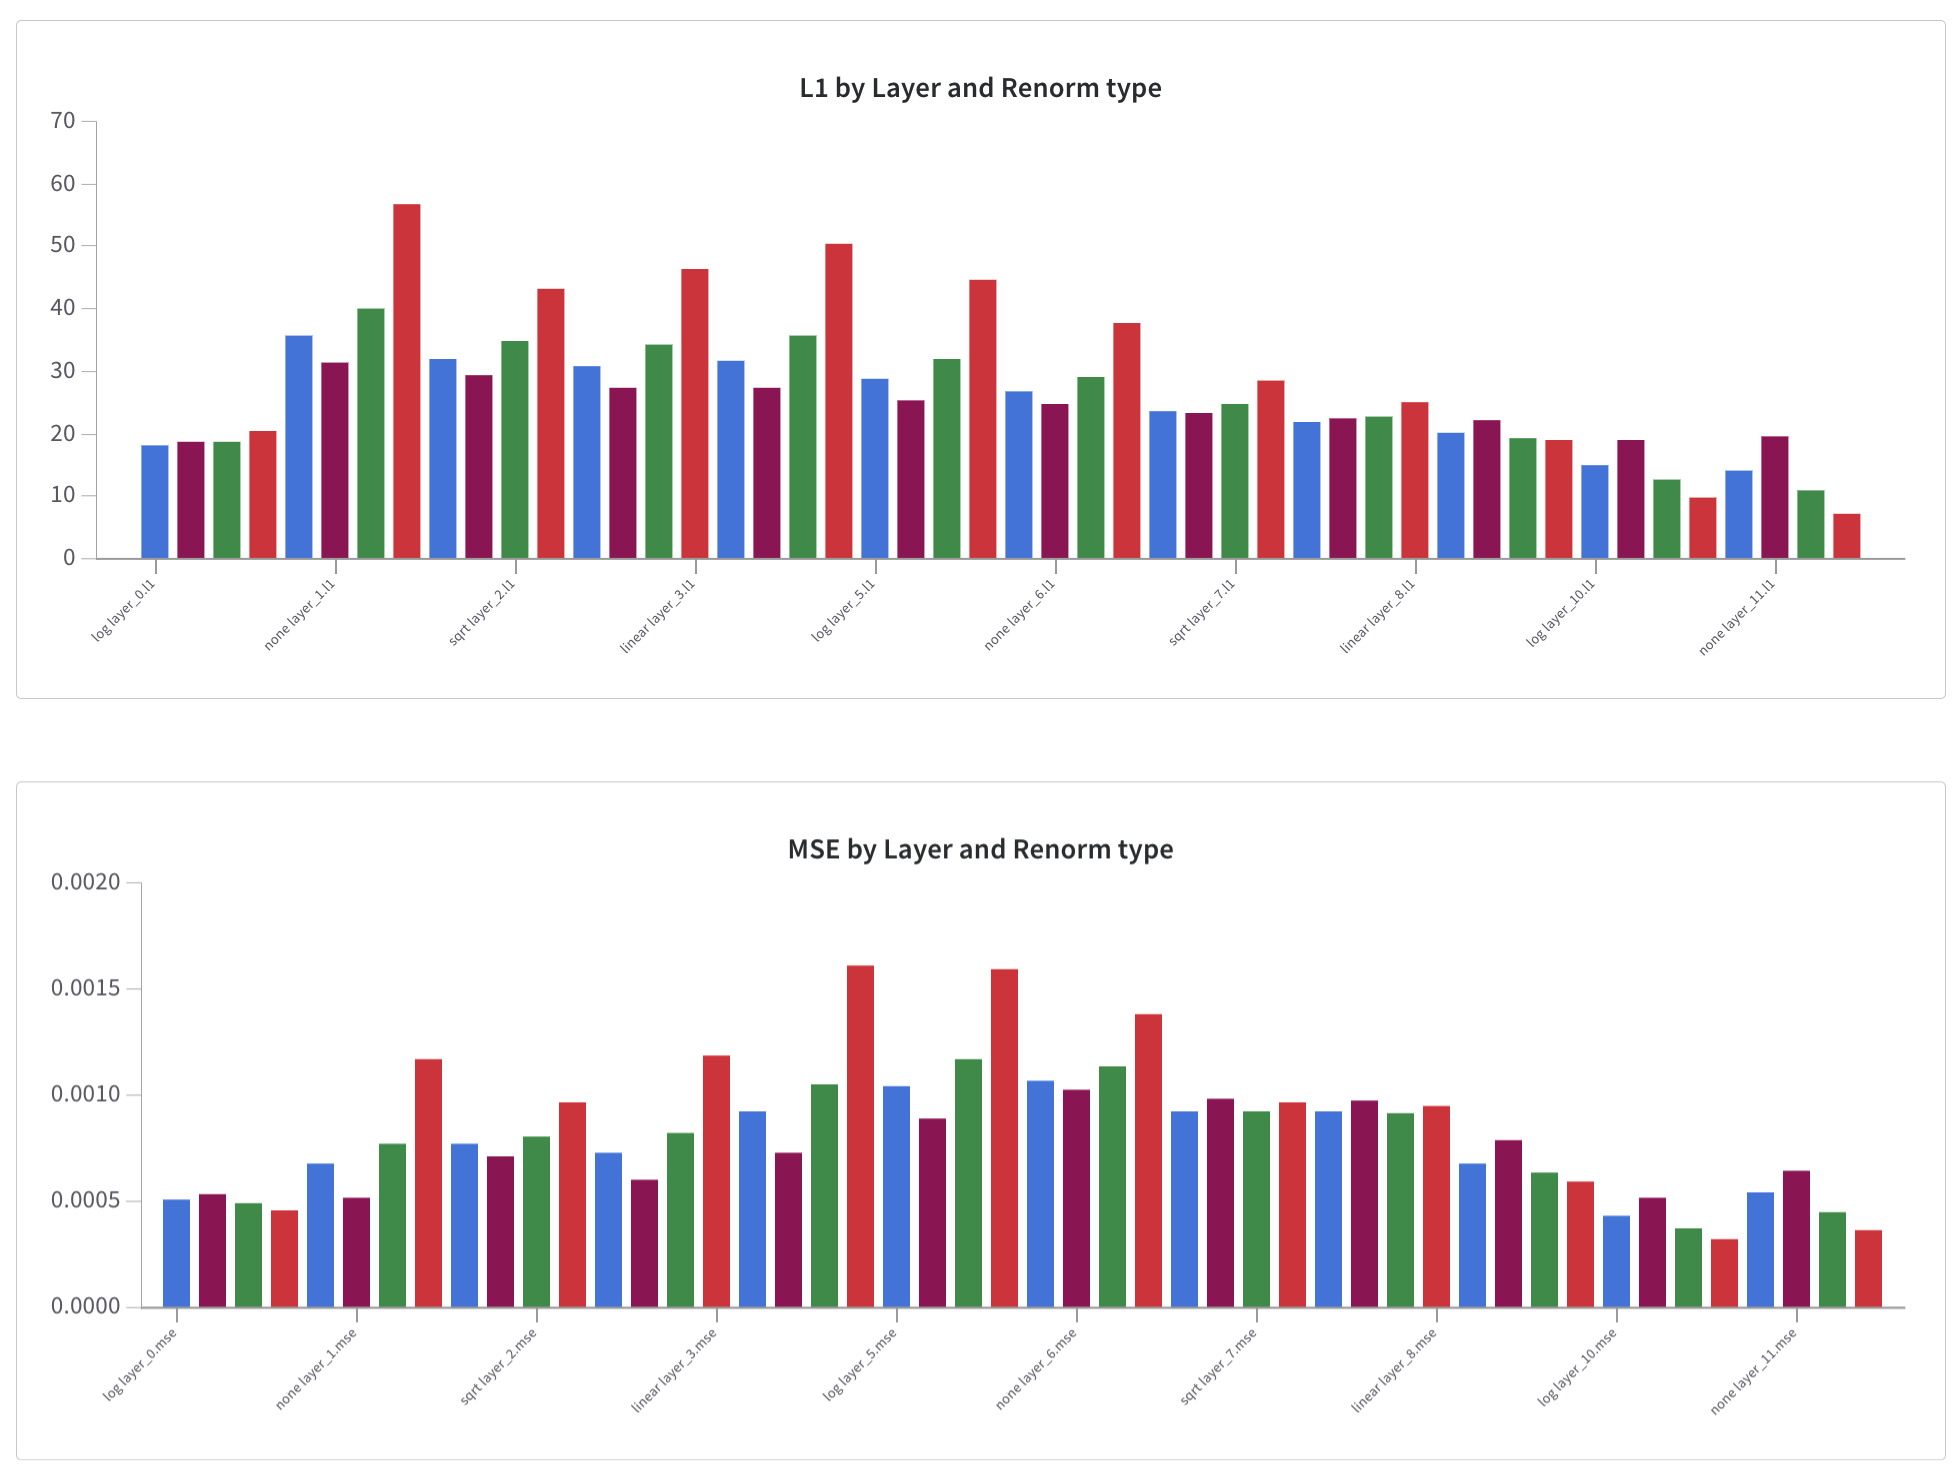

In [39]:
Image(filename='/home/collin/autoencoders/renorm_by_layer.png')

(The color of the bars represents the renormalization type used. See the interactive version in the link above, or just know that blue is log, purple is none, green is sqrt, and red is linear)

L1 follows the trend that you would expect, being correlated with the avg. l2 norm, and so all the rescaling types mostly follow the inverse of the average l2 by layer curve from before. For both L1 and MSE linear seems bad here, although both log and sqrt, particularly log, actually look better to me, in that they don't increase the averages too much, and seem like they could have the desired effect of not overweighing the later layers with higher activations. This is all quite speculative, ideally I would manually inspect the features, but this would be very time intensive, so instead I plan to train another model using what seem to be the best hyperparams from this sweep and manually inspect that one. 

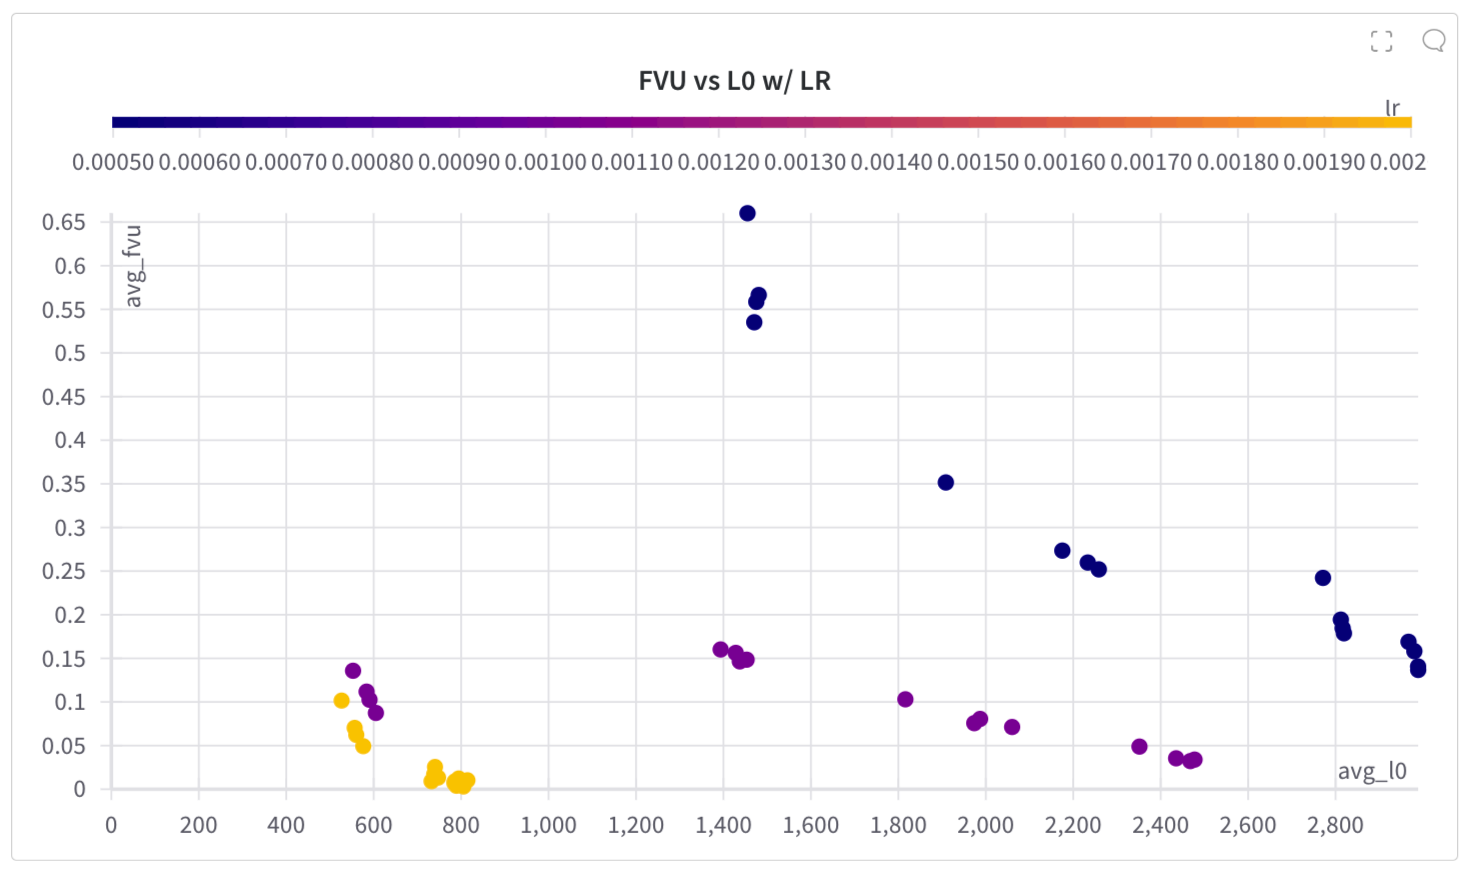

In [40]:
Image(filename='/home/collin/autoencoders/fvu_l0_multi.png')

The FVU v. L0 have a few notable things. One, they move down/left with an increase in learning rate, which is not what I would have expected, but may be a result of the relatively little training data. Second, and this is only directly viewable on the interactive version linked, the runs which differ only by the renorm type are all in clusters together, and in most cases become more sparse and lower in fvu going from no renorm -> log -> sqrt -> linear. I'm unsure how useful this is, as they seem to have a worse curve than you would get from varying the l1 regularization factor, that is fvu goes up more for the same amount of drop in l0 when changing the renorm type vs. the l1 reg factor. But, it is interesting because L0 is following a different trend in L1, so scaling the input activations can actually improve sparsity.


Based on all this, I'm going to train another using log activation renormalization and a larger dataset, and see if I can find any features in it which exist across layers

In [68]:
total_activations = int(5e8)
batch_size = 4096

autoencoder_cfg = AutoEncoderMultiLayerConfig(
    n_dim=768,
    m_dim=768 * 4,  # I think this should perhaps be raised
    act_norms=avg_norms,
    act_renorm_type="log",
    act_renorm_scale=1,
    lambda_reg=1e-3,
    record_data=True,
    seed=seed,
)

autoencoder_trainer_cfg = AutoEncoderMultiLayerTrainerConfig(
    lr=2e-3,
    beta1=0,
    beta2=0.99,
    total_steps=total_activations // batch_size,
    warmup_percent=0.05,
    wb_project="multilayer_sae",
    wb_entity="collingray",
    wb_name="gpt2_tinystories_multilayer",
    wb_config=autoencoder_cfg.__dict__,
)

In [69]:
autoencoder_trainer = AutoEncoderMultiLayerTrainer(autoencoder_cfg, autoencoder_trainer_cfg)

In [70]:
buffer.reset_dataset()

In [ ]:
try:
    for _ in tqdm(range(total_activations // batch_size)):
        acts = buffer.next(batch=batch_size).to(autoencoder_cfg.device, dtype=autoencoder_cfg.dtype)
        autoencoder_trainer.train_on(acts)
finally:
    autoencoder_trainer.finish()

I ended the training about halfway through, as most metrics had plateaued, and so only about 250 million activations were used. The full data can be found [here](https://wandb.ai/collingray/multilayer_sae/runs/hsnjbh9l).

This autoencoder has some issues, namely that there are many features which activate with extremely high frequency, and quite a few dead neurons, issues that could be improved with some more hyperparameter tuning and adding neuron resampling. I also realized an issue with my FVU calculation due to the rescaling of inputs These shouldn't matter for this proof of concept though, as I primarily want to see whether I can find *any* interpretable features which can occur across layers.

Shown below is the feature density of the final model, as log10(freq). Note that the discontinuity that occurs below ~10^-7^ is a result of the length of the sliding window used to count occurrences, and that 10^-10^ is the default value given to features which have not occurred in the window, and are almost certainly dead.

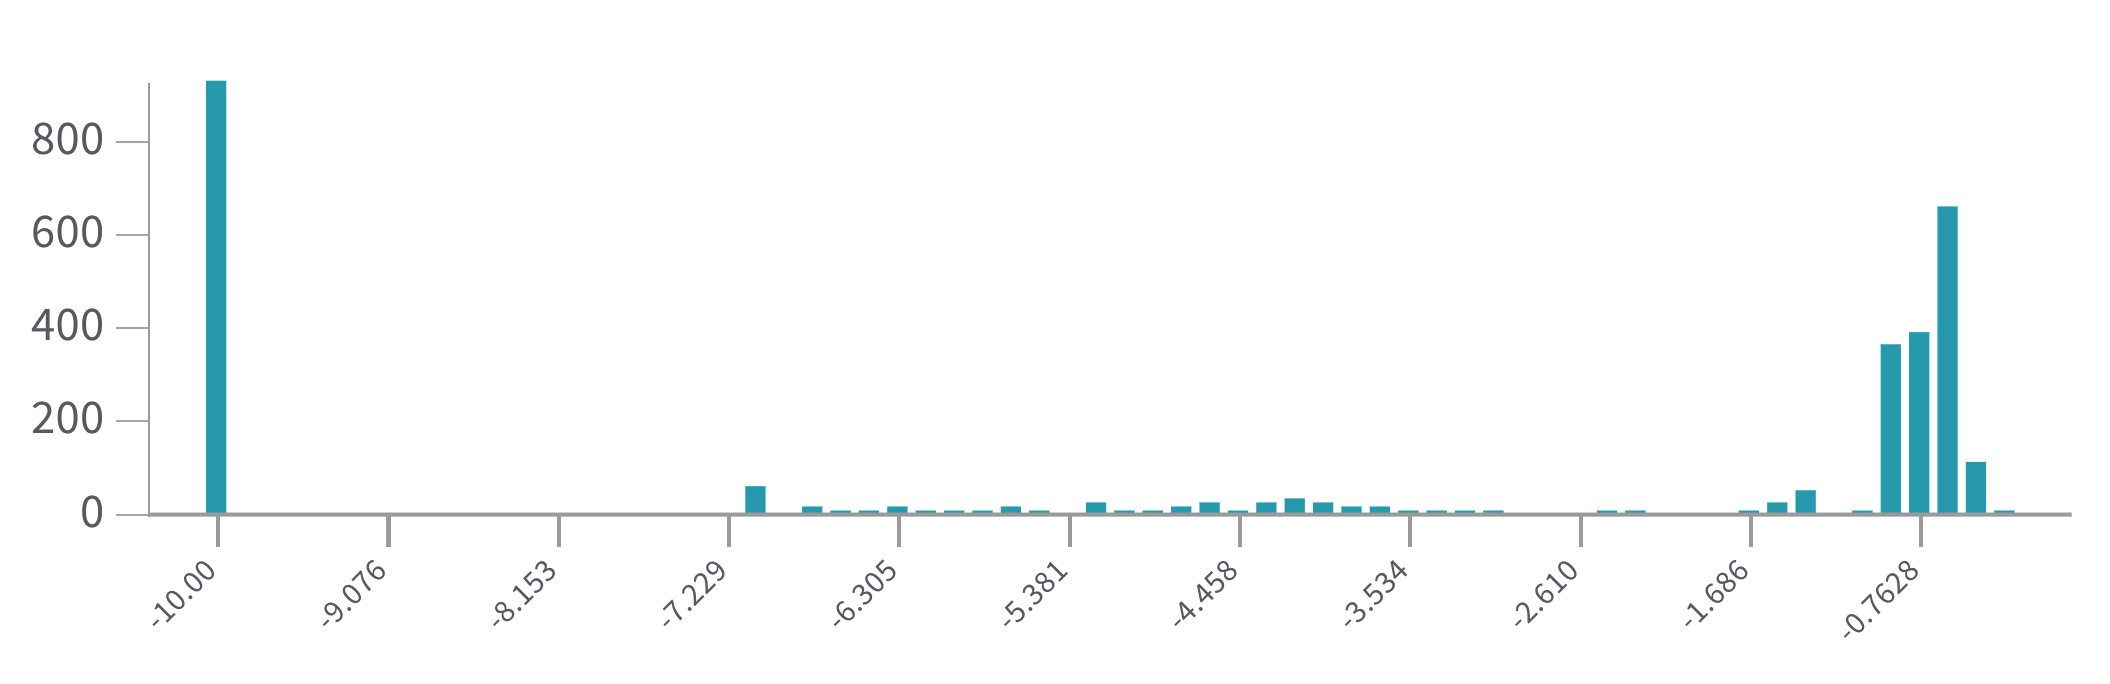

In [72]:
Image(filename='/home/collin/autoencoders/feature_density.png')

In order to try and find relevant features, I'm going to primarily search in the center of this distribution, starting with features that occur ~1/10000 of the time, since I suspect that they would be the most likely to contain interesting/interpretable features.

In [74]:
encoder = autoencoder_trainer.encoder

In [176]:
num_seqs = 4096
max_seq_length = 1024
num_layers = 12
act_names = [f"blocks.{i}.hook_mlp_out" for i in range(num_layers)]
context_width = 10  # number of tokens to include on either side of the feature when storing its example
m_dim = 768 * 4

feature_examples = [[] for _ in range(m_dim)]
feature_occurrences = torch.zeros(num_layers, m_dim, dtype=torch.int, device=encoder.cfg.device)

# since we have many features that activate with extremely high frequency, we mask out any feature once it occurs 1000 times
feature_mask = torch.ones(768 * 4, dtype=torch.bool, device=encoder.cfg.device)

In [177]:
for i in tqdm(range(num_seqs)):
    tokens = model.tokenizer(dataset["validation"]["text"][i], max_length=max_seq_length, return_tensors="pt")["input_ids"][0]
    token_strings = model.tokenizer.batch_decode(tokens)

    output, cache = model.run_with_cache(tokens, names_filter=act_names)
    mlp_outs = torch.stack([cache[act_name] for act_name in act_names])  # [num_layers, batch_dim, seq_length, n_dim]
    mlp_outs = mlp_outs.squeeze(dim=1).permute(1, 0, 2).to(dtype=encoder.cfg.dtype)  # [seq_length, num_layers, n_dim]
    out = encoder.encode(mlp_outs)  # [seq_length, num_layers, m_dim]


    activation_threshold = 0.0001  # only consider features that activate with at least 0.0001
    activated_features = out > activation_threshold  
    example_act_indices = torch.where(activated_features*feature_mask)
    
    feature_occurrences += activated_features.int().sum(dim=0)
    feature_mask = feature_occurrences.sum(dim=0) < 1000
    
    prev_seq = -1
    context = ""
    for seq, layer, feat in zip(*example_act_indices):
        if len(feature_examples[feat]) > 1000:
            continue
            
        if seq != prev_seq:  # if seq hasn't incremented, we don't need to recalculate the context
            prev_seq = seq
            start = max(0, seq - context_width)
            end = min(max_seq_length, seq + context_width + 1)
            idx = min(seq, context_width)
            context_tokens = token_strings[start:end]
            context_tokens[idx] = f"||{context_tokens[idx]}||"
            context = "".join(context_tokens)

        feature_examples[feat].append({
            "layer": layer.item(),
            "activation": out[seq, layer, feat].item(),
            "context": context
        })

  0%|          | 0/4096 [00:00<?, ?it/s]

In [194]:
possible_activations = num_seqs * max_seq_length * num_layers
upper_freq_bound = 1e-3
lower_freq_bound = 1e-5
upper_bound = possible_activations * upper_freq_bound
lower_bound = possible_activations * lower_freq_bound

# only consider features that occur between 1/100000 and 1/100 of the time
total_feature_occurrences = feature_occurrences.sum(dim=0)
in_bounds = feature_occurrences * ((total_feature_occurrences < upper_bound) & (total_feature_occurrences > lower_bound))
num_features = (in_bounds.sum(dim=0) > 0).sum().item()
num_features

465

In [205]:
layers_acted_on = in_bounds.count_nonzero(dim=0)
layers_acted_on.bincount()

tensor([2607,   94,   23,   10,   19,   26,   37,   52,   48,   44,   32,   27,
          53], device='cuda:0')

In [211]:
every_layer_idxs = torch.where(layers_acted_on == 12)[0] # features that activated at least once on every layer

In [215]:
for i in range(m_dim): # sort all the feature examples by activation score
    feature_examples[i].sort(key=lambda x: x["activation"], reverse=True)

In [265]:
def print_feature_summary(feature_idx, layers=range(12), examples_per_layer=3):
    feature = feature_examples[feature_idx]
    summary = ""
    for layer in layers:
        summary += f"~~~~~~~~~~ Layer {layer} ~~~~~~~~~~\n"
        layer_examples = [ex for ex in feature if ex["layer"] == layer]
        layer_examples = layer_examples[:examples_per_layer]
        for ex in layer_examples:
            act_score = ex["activation"]
            context = ex["context"].replace('\n', '\\n')
            summary += f"{act_score:.4f} : {context}\n\n"

    print(summary)

In [266]:
print_feature_summary(every_layer_idxs[0])

~~~~~~~~~~ Layer 0 ~~~~~~~~~~
0.7383 : \nA cheerful voice replied, "My name is|| Wally|| and I'm stuck in here! Please help me

0.6836 : ! He was always chewing on something ��€||�||� sticks, bones, even grass ��€

0.6680 :  named Susie. Susie loved animals and especially|| gor||illas. One day Susie thought of an idea

~~~~~~~~~~ Layer 1 ~~~~~~~~~~
0.3516 :  Lacey cheered with joy.\n\nâ€||�||�You are so gifted!â€ said L

0.3320 :  wanted to make things better, so she said,|| �||�€��Letâ€™s not

0.3086 : € \n\nBob was sad and shouted,|| �||�€��NO!â€ \n

~~~~~~~~~~ Layer 2 ~~~~~~~~~~
0.3945 :  started to climb. \n\nSlowly and|| steadily||, he went higher and higher. He reached the

0.3672 : , but the dog was too fast.\n\n||Luckily||, Timmy's mom saw what was happening and

0.2461 :  at them and croaked.\n\n"R||ib||bit, ribbit. Don't pinch me again

~~~~~~~~~~ Layer 3 ~~~~~~~~~~
0.4648 :  excited he started to jump around and shout "Z||oom||!" His mom smiled and said, "Let's

0.2734 : \n\

In [232]:
def get_average_activation(feature_idx):
    return feature_occurrences[:, feature_idx].float().mean().item()

In [249]:
multilayer_feats = list(torch.where(layers_acted_on >= 6)[0])  # features that activated on at least 6 layers
multilayer_feats.sort(key=get_average_activation, reverse=True) # sort by average activation across all layers

In [250]:
print_feature_summary(multilayer_feats[0])

~~~~~~~~~~ Layer 0 ~~~~~~~~~~
0.6172 : . At the fair, there was a slide.||\n||\nThe little girl was so excited to go down

0.6094 :  scared, so she went inside her house.\n||\n||Her mom told her that it was normal for storms

0.6094 :  was holding a letter that she had written.\n||\n||Lucy was feeling very brave. She looked both

~~~~~~~~~~ Layer 1 ~~~~~~~~~~
~~~~~~~~~~ Layer 2 ~~~~~~~~~~
~~~~~~~~~~ Layer 3 ~~~~~~~~~~
~~~~~~~~~~ Layer 4 ~~~~~~~~~~
~~~~~~~~~~ Layer 5 ~~~~~~~~~~
~~~~~~~~~~ Layer 6 ~~~~~~~~~~
~~~~~~~~~~ Layer 7 ~~~~~~~~~~
0.5938 :  the table and hit the floor. Lily frowned and|| said||, "No, Ben, you did it wrong

~~~~~~~~~~ Layer 8 ~~~~~~~~~~
0.1445 : € said Laceyâ€™s uncle.||\n||\nThe two laughed and kept on pushing the swing

~~~~~~~~~~ Layer 9 ~~~~~~~~~~
~~~~~~~~~~ Layer 10 ~~~~~~~~~~
~~~~~~~~~~ Layer 11 ~~~~~~~~~~
0.1602 :  farmer smiled. ��€��Raising|| the|| ladder means to lift it up. So, I

0.0938 :  of an idea. She decided to name a gorilla|| "||George". \n\nSusi

In [257]:
# average activation actually isn't a good proxy for features that activate strongly on different layers, since distributions like this can occur
feature_occurrences[:, multilayer_feats[0].item()]

tensor([33390,     0,     0,     1,     0,     3,     4,    26,    16,    12,
            1,   125], device='cuda:0', dtype=torch.int32)

In [258]:
multilayer_feats = list(torch.where(layers_acted_on >= 6)[0])  # features that activated on at least 6 layers
multilayer_feats.sort(key=lambda x: feature_occurrences[:, x].float().norm(p=0.5).item(), reverse=True) # sort by l0.5 norm instead

In [260]:
feature_occurrences[:, multilayer_feats[0].item()] # much better distribution

tensor([1186,  396,  112,  284,  299,  589, 1284, 1025,  837,  710,  156, 4579],
       device='cuda:0', dtype=torch.int32)

In [275]:
print_feature_summary(multilayer_feats[0], examples_per_layer=5) 

~~~~~~~~~~ Layer 0 ~~~~~~~~~~
2.8125 : ! He was always chewing on something ��€||�||� sticks, bones, even grass ��€

2.1406 : � sticks, bones, even grass ��€||�||� he was always chewing!\n\nOne day

1.4219 : byes. Benny went to bed with a happy|| tum||my from eating his melon and a happy heart

1.0781 : um.\n\nShe put some jam on a|| tw||elfth plate and gave it to herself. She said

1.0312 :  stick. They pretended it was a sword, a|| wand||, and more. They laughed and laughed, until

~~~~~~~~~~ Layer 1 ~~~~~~~~~~
0.8164 : . Lucy was sad but said goodbye and thanked the|| rabbit|| for the fun day. She waved to the bunny

0.7695 :  much.\n\nTim hugs his dad and says|| thank|| you. He is very happy. He puts the

0.5508 :  handed him the bucket. His brother smiled and said|| thank|| you. Tony felt happy when he saw his brother

0.5273 : Anna|| was|| a three-year-old who prided herself

0.4961 :  together to make things happen.\n\nThe lazy|| rabbit|| felt sad and messy inside. He realized t

In [276]:
# For some reason, lots of features activate on names in the final layer. In the sample below 8/20
# Although this might be because names are very easy to detect, and so they get high activation, which I sorted by
for i in range(20):
    print_feature_summary(multilayer_feats[i], layers=[11], examples_per_layer=5) 

~~~~~~~~~~ Layer 11 ~~~~~~~~~~
4.4062 : ||Tony|| had a bucket. He was very lazy and he

4.1250 : ||Joe||y was three years old and he loved to learn

4.1250 : ||Joe||y was so excited. His mom and dad had

4.0312 : ||Jeff|| was a brave child. His mom gave him a

3.9688 : ||Tim|| and Sam are friends. They like to play with


~~~~~~~~~~ Layer 11 ~~~~~~~~~~
18.6250 : ||Tony|| had a bucket. He was very lazy and he

17.0000 : ||Lisa|| loved to take pictures with her camera. She liked

16.8750 : ||Ben|| and Lily were playing in the park with their ball

16.8750 : ||Johnny|| loved to watch the dancers. Every day he would

16.7500 : ||James|| opened his eyes and saw a big flag. It


~~~~~~~~~~ Layer 11 ~~~~~~~~~~
5.1562 : ||Tony|| had a bucket. He was very lazy and he

4.7188 : ||Joe||y was three years old and he loved to learn

4.7188 : ||Joe||y was so excited. His mom and dad had

4.5938 : ||Jeff|| was a brave child. His mom gave him a

4.4375 : ||Tim|| and Sam are friends. They like to play w

In [283]:
print_feature_summary(multilayer_feats[16], examples_per_layer=10) # !!! cool feature, it mostly activates on the word "the", but only in the first and last layers (and a stray single activation in the 8th)

~~~~~~~~~~ Layer 0 ~~~~~~~~~~
0.8633 :  you anymore." She pushed Ben away and took all|| the|| blocks. She said, "Go away, Ben

0.8398 :  make a tower. He did not mean to waste|| the|| blocks or make a mess. He did not think

0.8398 :  boy was playing outside when he saw something sour on|| the|| ground. It was a tiny green sour fruit!

0.8242 : andy had to clean up before she could play with|| the|| video. But Mandy kept forgetting and her mom

0.8242 :  She was swinging when she noticed a little pocket on|| the|| swing. She wanted to know what was inside so

0.7930 :  better. She put on her shoes and went to|| the|| store. Sally bought some food with her piggy

0.7930 : . One day, a little boy came to visit|| the|| jungle and saw the gorilla. He stared at the

0.7852 : Her dad said he went to the shop to find|| the|| perfect bike. He looked at lots of different ones

0.7852 :  don't you go outside and have some fun in|| the|| sunshine?". \n\nSadie excitedly said

0.7773 :  had an ama

In [288]:
print_feature_summary(multilayer_feats[40], examples_per_layer=5)  # activates on newlines in both the second and third layers

~~~~~~~~~~ Layer 0 ~~~~~~~~~~
0.7148 : I don't know, Ben. Maybe we can|| fold|| it or cut it," Lila says.\n

0.5273 :  clean her room to help forget her nightmare. She|| tid||ied her toys and put everything in order. 

0.4805 : .\n\nLily cried and cried. She|| wished|| she had never found the microphone. She wished she

0.4492 :  never found the microphone. She wished she had never|| whispered|| that secret. She wished she had been kind to

0.4180 : . He thought making a tower was difficult. He|| wished|| Lily would be nice to him and help him.

~~~~~~~~~~ Layer 1 ~~~~~~~~~~
0.4414 :  head to the lake to catch some fish.\n||\n||One day, unfortunately, the fisherman couldn't catch

0.4258 :  He was very cheerful and loved playing pretend.\n||\n||One day, Tim was playing in his garden and

0.4180 :  was always sneaking around, getting into trouble.\n||\n||One day, Tim was playing with a folder when

0.3867 :  They all lived together and were very happy.\n||\n||One day, a little human boy

In [291]:
print_feature_summary(multilayer_feats[37], examples_per_layer=5) # activates on newlines in a few different layers, but lots of other noise

~~~~~~~~~~ Layer 0 ~~~~~~~~~~
0.1016 :  on a tenth plate and gave it to the big|| doll||. She said, "This is your jam.

~~~~~~~~~~ Layer 1 ~~~~~~~~~~
~~~~~~~~~~ Layer 2 ~~~~~~~~~~
~~~~~~~~~~ Layer 3 ~~~~~~~~~~
0.1641 :  trying to balance his body as he moved up and|| down||. One day, Andy was playing neatly with his

0.0547 : The peanut was then moved around quickly, up and|| down|| and side to side. It was like a ride

0.0195 :  Mom works. Mom says they can go up and|| down|| the elevator, but they have to stay with her

~~~~~~~~~~ Layer 4 ~~~~~~~~~~
~~~~~~~~~~ Layer 5 ~~~~~~~~~~
0.1562 :  to Billy. But when Timmy gave the soldier|| to|| Billy, Billy didn't want it either. Billy

0.0703 :  close to him and he just looked at it.||\n||\nOne day, Tony's mom said, "

0.0156 :  to put them in. She wants to give them|| to|| her mom.\n\nOne day, she goes

~~~~~~~~~~ Layer 6 ~~~~~~~~~~
0.3906 :  must be something special about this tree.â€||\n||\nJimmy wanted to find out, so he ran

0.0938 : 